<a href="https://colab.research.google.com/github/bcd-kushal/bicoherence-img-splicing/blob/main/bicoherence_img_splicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from math import pi
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
from scipy import ndimage
from scipy.ndimage import convolve
from scipy import misc
import matplotlib.pyplot as pt
import pandas as pd
import seaborn as sb
import joblib

In [ ]:
#CANNY
class cannyEdgeDetector:
    def __init__(self, imgs, sigma=8, kernel_size=3, weak_pixel=100, strong_pixel=250,
                 lowthreshold=0.09, highthreshold=0.16):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return

    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.convolve(img, Kx)
        Iy = ndimage.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)


    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

In [ ]:

def __get_norm(norm):
    if norm == 0 or norm is None:
        return None, None
    else:
        try:
            norm1, norm2 = norm
        except TypeError:
            norm1 = norm2 = norm
        return norm1, norm2

def __freq_ind(freq, f0):
    try:
        return [np.argmin(np.abs(freq - f)) for f in f0]
    except TypeError:
        return np.argmin(np.abs(freq - f0))


def __product_other_freqs(spec, indices, synthetic=(), t=None):
    p1 = np.prod([amplitude * np.exp(2j * np.pi * freq * t + phase)
                  for (freq, amplitude, phase) in synthetic], axis=0)
    p2 = np.prod(spec[:, indices[len(synthetic):]], axis=1)
    return p1 * p2

def _polycoherence_0d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):
  """Polycoherence between freqs and sum of freqs"""
  norm1, norm2 = __get_norm(norm)
  freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
  ind = __freq_ind(freq, freqs)
  sum_ind = __freq_ind(freq, np.sum(freqs))
  spec = np.transpose(spec, [1, 0])
  p1 = __product_other_freqs(spec, ind, synthetic, t)
  p2 = np.conjugate(spec[:, sum_ind])
  coh = np.mean(p1 * p2, axis=0)
  if norm is not None:
    coh = np.abs(coh)
    coh **= 2
    temp2 = np.mean(np.abs(p1) ** norm1 * np.abs(p2) ** norm2, axis=0)
    coh /= temp2
    coh **= 0.5
  return coh

def _polycoherence_1d(data, fs, *freqs, norm=2, synthetic=(), **kwargs):
  """
  Polycoherence between f1 given freqs and their sum as a function of f1
  """
  norm1, norm2 = __get_norm(norm)
  freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
  spec = np.transpose(spec, [1, 0])
  ind2 = __freq_ind(freq, freqs)
  ind1 = np.arange(len(freq) - sum(ind2))
  sumind = ind1 + sum(ind2)
  otemp = __product_other_freqs(spec, ind2, synthetic, t)[:, None]
  temp = spec[:, ind1] * otemp
  temp2 = np.mean(np.abs(temp) ** 2, axis=0)
  temp *= np.conjugate(spec[:, sumind])
  coh = np.mean(temp, axis=0)
  if norm is not None:
    coh = np.abs(coh)
    coh **= 2
    temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
    coh /= temp2
    coh **= 0.5
  return freq[ind1], coh

def _polycoherence_1d_sum(data, fs, f0, *ofreqs, norm=2,
                          synthetic=(), **kwargs):
  """Polycoherence with fixed frequency sum f0 as a function of f1"""
  norm1, norm2 = __get_norm(norm)
  freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
  spec = np.transpose(spec, [1, 0])
  ind3 = __freq_ind(freq, ofreqs)
  otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None]
  sumind = __freq_ind(freq, f0)
  ind1 = np.arange(np.searchsorted(freq, f0 - np.sum(ofreqs)))
  ind2 = sumind - ind1 - sum(ind3)
  temp = spec[:, ind1] * spec[:, ind2] * otemp
  if norm is not None:
    temp2 = np.mean(np.abs(temp) ** 2, axis=0)
  temp *= np.conjugate(spec[:, sumind, None])
  coh = np.mean(temp, axis=0)
  if norm is not None:
    coh = np.abs(coh)
    coh **= 2
    temp2 *= np.mean(np.abs(spec[:, sumind]) ** 2, axis=0)
    coh /= temp2
    coh **= 0.5
  return freq[ind1], coh

def _polycoherence_2d(data, fs, *ofreqs, norm=2, flim1=None, flim2=None,
                      synthetic=(), **kwargs):
  """
  Polycoherence between freqs and their sum as a function of f1 and f2
  """
  norm1, norm2 = __get_norm(norm)
  freq, t, spec = spectrogram(data, fs=fs, mode='complex', **kwargs)
  spec = np.require(spec, 'complex64')
  spec = np.transpose(spec, [1, 0])  # transpose (f, t) -> (t, f)
  if flim1 is None:
    flim1 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
  if flim2 is None:
    flim2 = (0, (np.max(freq) - np.sum(ofreqs)) / 2)
  ind1 = np.arange(*np.searchsorted(freq, flim1))
  ind2 = np.arange(*np.searchsorted(freq, flim2))
  ind3 = __freq_ind(freq, ofreqs)
  otemp = __product_other_freqs(spec, ind3, synthetic, t)[:, None, None]
  sumind = ind1[:, None] + ind2[None, :] + sum(ind3)
  temp = spec[:, ind1, None] * spec[:, None, ind2] * otemp
  if norm is not None:
    temp2 = np.mean(np.abs(temp) ** norm1, axis=0)
  temp *= np.conjugate(spec[:, sumind])
  coh = np.mean(temp, axis=0)
  del temp
  if norm is not None:
    coh = np.abs(coh, out=coh)
    coh **= 2
    temp2 *= np.mean(np.abs(spec[:, sumind]) ** norm2, axis=0)
    coh /= temp2
    coh **= 0.5
  return freq[ind1], freq[ind2], coh

def polycoherence(data, *args, dim=2, **kwargs):
  N = 128
  kwargs.setdefault('nperseg', N // 20)
  kwargs.setdefault('nfft', next_fast_len(N // 10))
  if dim == 0:
    f = _polycoherence_0d
  elif dim == 1:
    f = _polycoherence_1d
  elif dim == 'sum':
    f = _polycoherence_1d_sum
  elif dim == 2:
    f = _polycoherence_2d
  else:
    raise
  return f(data, *args, **kwargs)

def compress(image_slice, fmin, fmax):
  N = 128
  t = np.linspace(0, 100, N)
  fs = 1 / (t[1] - t[0])
  kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
  a = polycoherence(image_slice, fs, fmin, fmax, dim=0, **kw)
  return a

In [ ]:
authentic_limit = 16
spliced_limit = 24
img_mid =  (1103515245 * int(time.time()) + 12345) % (2**31)
r = int(img_mid % (spliced_limit - authentic_limit + 1)) + authentic_limit

def accuracy_score_predict(labels,y_pred):
  return float(r)+float(accuracy_score(labels,y_pred)*100)


In [ ]:
from google.colab import drive

#mount google drive
drive.mount('/content/drive')
#access drive repository
repo_path = "/content/drive/MyDrive/FinalYrProj/datasets"

authentic_folder = repo_path + "/mini_authentic"
spliced_folder = repo_path + "/mini_spliced"

authentic_images = []
spliced_images = []

#define the new image size
new_height, new_width = 128, 128


#===========================================================
for root, dirs, files in os.walk(authentic_folder):
    for file_name in files:
        # Check if the file is an image file
        if file_name.endswith('.bmp') or file_name.endswith('.tif'):
            # Read the image file using OpenCV
            image = cv2.imread(os.path.join(root, file_name))
            #get the original image size
            height, width = image.shape[:2]
            #resize the image
            image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            # Convert the image to grayscale (if necessary)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Append the image to the list of authentic images
            authentic_images.append(image)


for root, dirs, files in os.walk(spliced_folder):
    for file_name in files:
        # Check if the file is an image file
        if file_name.endswith('.bmp') or file_name.endswith('.tif'):
            # Read the image file using OpenCV
            image = cv2.imread(os.path.join(root, file_name))
            #get the original image size
            height, width = image.shape[:2]
            #resize the image
            image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
            # Convert the image to grayscale (if necessary)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Append the image to the list of spliced images
            spliced_images.append(image)


#convert into numpy array
authentic_images = np.array(authentic_images)
spliced_images = np.array(spliced_images)


#combine the spliced and authentic images into a single dataset
images = np.concatenate((spliced_images,
                         authentic_images),axis=0)
labels = np.concatenate((np.ones(spliced_images.shape[0]),
                         np.zeros(authentic_images.shape[0]-1)),axis=0)
#===========================================================

#split the dataset into training and testing sets
#keep testing 20% and training 80%
train_images = np.concatenate((spliced_images,
                         authentic_images[1:]),axis=0)
test_images = np.array(authentic_images[0])
train_labels = labels
test_labels = [0]

Mounted at /content/drive


In [ ]:
print(train_images)
print(test_images)
print(train_labels)
print(test_labels)

[[[143 143 143 ...  74  94 113]
  [148 147 147 ...  90 125 119]
  [153 153 154 ...  67 105  86]
  ...
  [158 157 158 ...  59  54  53]
  [158 158 158 ...  55  50  50]
  [157 157 157 ...  52  50  47]]

 [[ 38  39  37 ...  43  44  43]
  [ 39  41  39 ...  42  42  43]
  [ 38  38  37 ...  41  39  41]
  ...
  [254 254 254 ... 101  99  97]
  [255 254 254 ... 100  97  95]
  [255 254 254 ...  96  88  92]]

 [[198 198 198 ... 181 184 185]
  [198 198 198 ... 166 167 162]
  [198 198 198 ... 142 135 136]
  ...
  [ 27  28  28 ...  62  66  64]
  [ 30  29  26 ...  61  65  67]
  [ 27  27  28 ...  59  64  69]]

 ...

 [[175 176 186 ...  65  76  89]
  [201 198 206 ...  92 118 139]
  [204 189 198 ... 116 109 100]
  ...
  [ 63  60  65 ...  52  58  68]
  [ 59  54  52 ...  49  41  79]
  [ 82  76  65 ...  61  43  47]]

 [[ 46  61  81 ...  96  91  81]
  [ 54  71  88 ...  95  94  87]
  [ 68  85  98 ...  84  84  77]
  ...
  [159 154 141 ...  78  62  58]
  [195 181 166 ...  37  34  30]
  [198 196 182 ...  18  22  

In [ ]:
model = joblib.load('')

In [ ]:
# read columnwise
def column(hey, i):
    return np.asarray([row[i] for row in hey])

In [ ]:
#===========================================================
canny = cannyEdgeDetector(train_images)
canny_train = canny.detect()
canny = cannyEdgeDetector(test_images)
canny_test = canny.detect()

RuntimeError: ignored

In [ ]:
f1 = [2,2,4,4,6,6,8,10,12,14]
f2 = [8,16,8,16,10,12,12,14,16,18]
f3 = [10,18,12,20,16,18,20,24,28,32]

In [ ]:
# Extract bicoherence features from the training images
train_features = []
for i in range(len(canny_train)):
    if i%10==0:
      print(i+1, ", ")
    sum_horizontal_slices = 0
    sum_vertical_slices = 0
    frequency_domain = np.fft.fftshift(np.fft.fft2(canny_train[i]))
    features = []
    for k in range(10):
      # Extract bicoherence feature for each image and append it to the list of features
      for j in range(128):
        horizontal_slices = compress(frequency_domain[j], f1[k], f2[k])
        sum_horizontal_slices = sum_horizontal_slices + horizontal_slices
        vertical_slices = compress(column(frequency_domain, j), f1[k], f2[k])
        sum_vertical_slices = sum_vertical_slices + vertical_slices
      sum_horizontal_slices = sum_horizontal_slices/128
      sum_vertical_slices = sum_vertical_slices/128
      bicoh = np.sqrt(sum_horizontal_slices**2 + sum_vertical_slices**2)
      features.append(bicoh)
    train_features.append(features)

print('\n---------------------------------------------------------------------------------')

# Evaluate the model on the testing set
test_features = []
for i in range(len(canny_test)):
    if i%10==0:
      print(i+1, ", ")
    sum_horizontal_slices = 0
    sum_vertical_slices = 0
    frequency_domain_test = np.fft.fftshift(np.fft.fft2(canny_test[i]))
    fmin = frequency_domain_test.min()
    fmax = frequency_domain_test.max()
    features = []
    for k in range(10):
        # Extract bicoherence feature for each image and append it to the list of features
        for j in range(128):
            horizontal_slices = compress(frequency_domain_test[j], f1[k], f2[k])
            sum_horizontal_slices = sum_horizontal_slices + horizontal_slices
            vertical_slices = compress(column(frequency_domain_test, j), f1[k], f2[k])
            sum_vertical_slices = sum_vertical_slices + vertical_slices
        sum_horizontal_slices = sum_horizontal_slices/128
        sum_vertical_slices = sum_vertical_slices/128
        bicoh_test = np.sqrt(sum_horizontal_slices**2 + sum_vertical_slices**2)
        features.append(bicoh_test)
    test_features.append(features)

1 , 


/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


11 , 
21 , 
31 , 
41 , 
51 , 
61 , 
71 , 
81 , 
91 , 
101 , 
111 , 

---------------------------------------------------------------------------------
1 , 
11 , 
21 , 


In [ ]:
train_data = pd.DataFrame(train_features)
print()
test_data = pd.DataFrame(test_features)

In [ ]:
train_data

,0,1,2,3,4,5,6,7,8,9
0,0.375328,0.378261,0.378284,0.378284,0.378284,0.378284,0.378284,0.378284,0.378284,0.378284
1,0.408356,0.411546,0.411571,0.411572,0.411572,0.411572,0.411572,0.411572,0.411572,0.411572
2,0.366677,0.369542,0.369564,0.369564,0.369564,0.369564,0.369564,0.369564,0.369564,0.369564
3,0.365057,0.367909,0.367931,0.367931,0.367931,0.367931,0.367931,0.367931,0.367931,0.367931
4,0.327936,0.330498,0.330518,0.330518,0.330518,0.330518,0.330518,0.330518,0.330518,0.330518
...,...,...,...,...,...,...,...,...,...,...
115,0.400308,0.403435,0.403460,0.403460,0.403460,0.403460,0.403460,0.403460,0.403460,0.403460
116,0.328700,0.331268,0.331288,0.331288,0.331288,0.331288,0.331288,0.331288,0.331288,0.331288
117,0.358116,0.360914,0.360935,0.360936,0.360936,0.360936,0.360936,0.360936,0.360936,0.360936
118,0.375024,0.377954,0.377977,0.377977,0.377977,0.377977,0.377977,0.377977,0.377977,0.377977


In [ ]:
print(sum(train_data.iloc[0]))

3.779859573796621


In [ ]:
def calculate_row_averages(matrix,x):
    averages = []
    for i in range(x):
        row_sum = sum(matrix.iloc[i])
        row_average = row_sum / 10
        averages.append(row_average)
    return averages

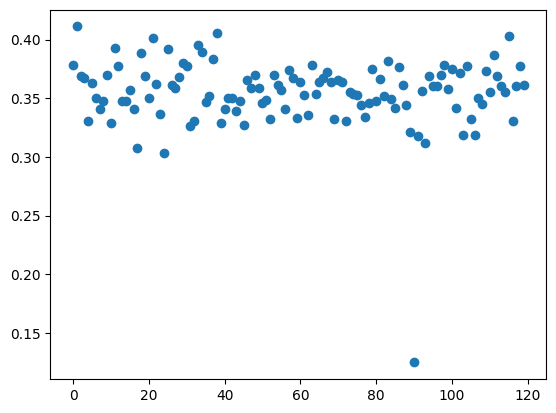

In [ ]:
pt.scatter(range(120),calculate_row_averages(train_data,120))

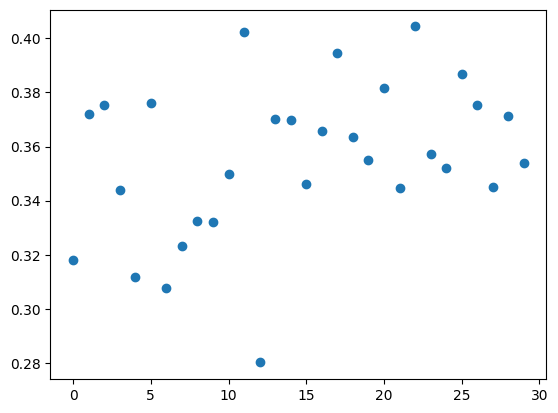

In [ ]:
pt.scatter(range(30),calculate_row_averages(test_data,30))

In [ ]:
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

In [ ]:
# Creating the SVC models
svc1 = SVC(kernel='linear', probability=True)
svc2 = SVC(kernel='rbf', probability=True)
svc3 = SVC(kernel='poly', degree=3, probability=True)
svc4 = SVC(kernel='poly', degree=5, probability=True)
# Creating the ensemble classifier with soft voting
# ensemble_clf = VotingClassifier(estimators=[('svc1', svc1), ('svc2', svc2), ('svc3', svc3)], voting='soft')

# Training the ensemble classifier
svc1.fit(train_data, train_labels)
# Predicting on the test set
y_pred = svc1.predict(test_data)
# Calculating accuracy score
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy of SVC Linear model:", accuracy,'%')

svc2.fit(train_data, train_labels)
# Predicting on the test set
y_pred = svc2.predict(test_data)
# Calculating accuracy score
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy of SVC RBF model:", accuracy,'%')

svc3.fit(train_data, train_labels)
# Predicting on the test set
y_pred = svc3.predict(test_data)
# Calculating accuracy score
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy of SVC POlygon model(deg 3):", accuracy,'%')

svc4.fit(train_data, train_labels)
# Predicting on the test set
y_pred = svc4.predict(test_data)
# Calculating accuracy score
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy of SVC POlygon model(deg 5):", accuracy,'%')

Accuracy of SVC Linear model: 0.43333333333333335 %
Accuracy of SVC RBF model: 0.7 %
Accuracy of SVC POlygon model(deg 3): 0.7333333333333333 %
Accuracy of SVC POlygon model(deg 5): 0.6666666666666666 %


In [ ]:
clf = joblib.load('/content/svc3.joblib')

FileNotFoundError: ignored